## Install Packages

In [1]:
# pyspark

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d977e9c485e25917863caff20c730c8d326cc172623156bb11e76b5d1437ffdc
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!pip install -U textblob

In [3]:
!pip install tensorflow

In [4]:
!pip install gensim

In [5]:
!pip install wordcloud

In [6]:
!pip install plotly

In [7]:
!pip install statsmodels

In [8]:
!pip install scikit-learn

In [9]:
!pip install statsmodels

## Import Libraries

In [1]:
################################################### spark #################################################################

from pyspark.sql import SparkSession

################################################### base #################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################### nlp #################################################################

import numpy as np

import gensim
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

################################################### time series #################################################################



from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.corpus import stopwords as nltk_stopwords

###################################################  ml #################################################################

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

################################################# confusion matrix #################################################################

from sklearn.metrics import confusion_matrix

## Ignore Warnings

In [15]:
# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Create Spark

In [11]:
spark=SparkSession.builder.appName('ProjectTweets').getOrCreate()

In [12]:
spark

## Read Dataset

In [13]:
## read the dataset
tweets=spark.read.option('header','true').csv('/content/ProjectTweets.csv',inferSchema=True)

## Upload Dataset and Showing Data

In [14]:
tweets=spark.read.csv('/content/ProjectTweets.csv',header=True,inferSchema=True)
tweets.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

## Showing Schema

In [15]:
### Check the schema
tweets.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



## Types data

In [16]:
type(tweets)

pyspark.sql.dataframe.DataFrame

## Head dataset

In [17]:
tweets.head(3)

[Row(0=1, 1467810369=1467810672, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:49 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='scotthamilton', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(0=2, 1467810369=1467810917, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:53 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='mattycus', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(0=3, 1467810369=1467811184, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:57 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='ElleCTF', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D='my whole

## Add Column Names

In [20]:
# Add column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]
tweets = tweets.toDF(*column_names)

In [23]:
tweets.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|  id_tweet|                date|   query|        user_id|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|     9|1467812025|Mon Apr 06 22:20:...|NO_

## Show Column Names

In [24]:
tweets.columns

['number', 'id_tweet', 'date', 'query', 'user_id', 'tweet']

## Show Schema

In [25]:
tweets.printSchema()

root
 |-- number: integer (nullable = true)
 |-- id_tweet: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



## Show Dtypes

In [26]:
tweets.dtypes

[('number', 'int'),
 ('id_tweet', 'bigint'),
 ('date', 'string'),
 ('query', 'string'),
 ('user_id', 'string'),
 ('tweet', 'string')]

## Drop Column Names

In [27]:
##drop the columns
tweets.drop('number').show()

+----------+--------------------+--------+---------------+--------------------+
|  id_tweet|                date|   query|        user_id|               tweet|
+----------+--------------------+--------+---------------+--------------------+
|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|1467812025|Mon Apr 06 22:20:...|NO_QUERY|        mimismo|@twittera que me ...|
|1467812416|Mon Apr 06 22:20:...|NO_QUER

## Count the number of tweets

In [29]:
# Count the number of tweets
total_tweets = tweets.count()
print(f"Total number of tweets: {total_tweets}")

Total number of tweets: 1599999


## Count the number of unique users

In [30]:
# Count the number of unique users
unique_users = tweets.select("user_id").distinct().count()
print(f"Number of unique users: {unique_users}")

Number of unique users: 659775


## Calculate the number of tweets per user

In [32]:
# Calculate the number of tweets per user
tweets_per_user = tweets.groupBy("user_id").count().orderBy("count", ascending=False)
tweets_per_user.show()

+---------------+-----+
|        user_id|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|   TraceyHewins|  211|
|     nuttychris|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



## Convert PySpark DataFrame to Pandas

In [2]:
#read dataset
project_tweets = pd.read_csv("ProjectTweets.csv", encoding = 'latin', header=None)


In [3]:
project_tweets = project_tweets.rename(columns={0: 'number', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'tweets'})

## Head

In [4]:
project_tweets.head()

,number,id,date,query,username,tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Tail

In [38]:
project_tweets.tail()

,number,id,date,query,username,tweets
1599995,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


## Information

In [39]:
project_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   number    1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   tweets    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Cheking Missing Values

In [40]:
project_tweets.isna().sum()

number      0
id          0
date        0
query       0
username    0
tweets      0
dtype: int64

## Shape

In [41]:
project_tweets.shape

(1600000, 6)

## Data Visualization

Length Tweets

<Axes: >

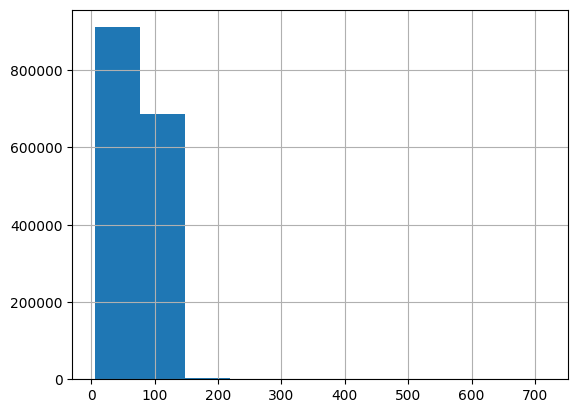

In [42]:
project_tweets['tweets'].str.len().hist()

Mean Tweets

<Axes: >

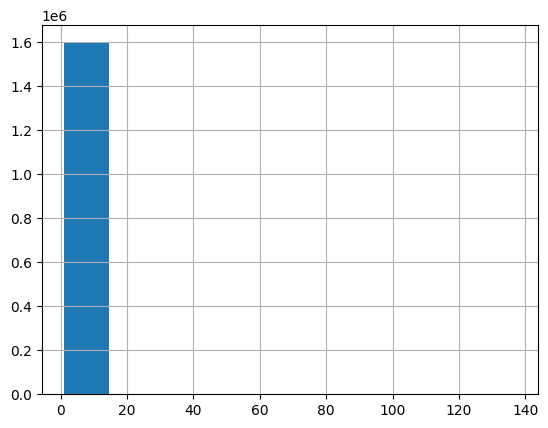

In [43]:
project_tweets['tweets'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [44]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
def plot_top_stopwords_barchart(tweets):
    stop=set(stopwords.words('english'))

    new= tweets.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)

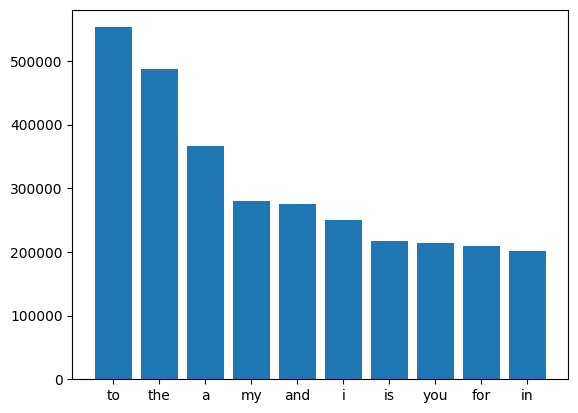

In [46]:
plot_top_stopwords_barchart(project_tweets['tweets'])

In [47]:
from nltk.corpus import stopwords
from collections import  Counter

In [48]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

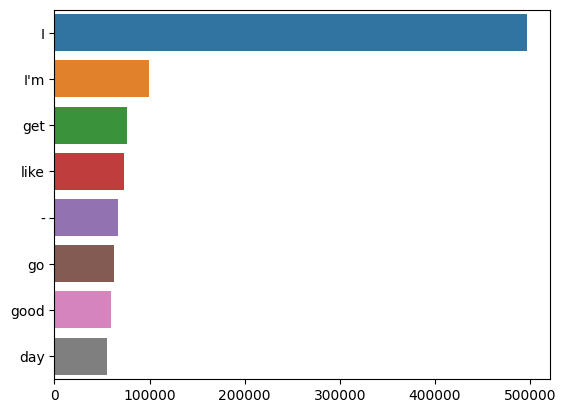

In [49]:
plot_top_non_stopwords_barchart(project_tweets['tweets'])

## World Cloud

In [50]:
# word cloud

#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [51]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

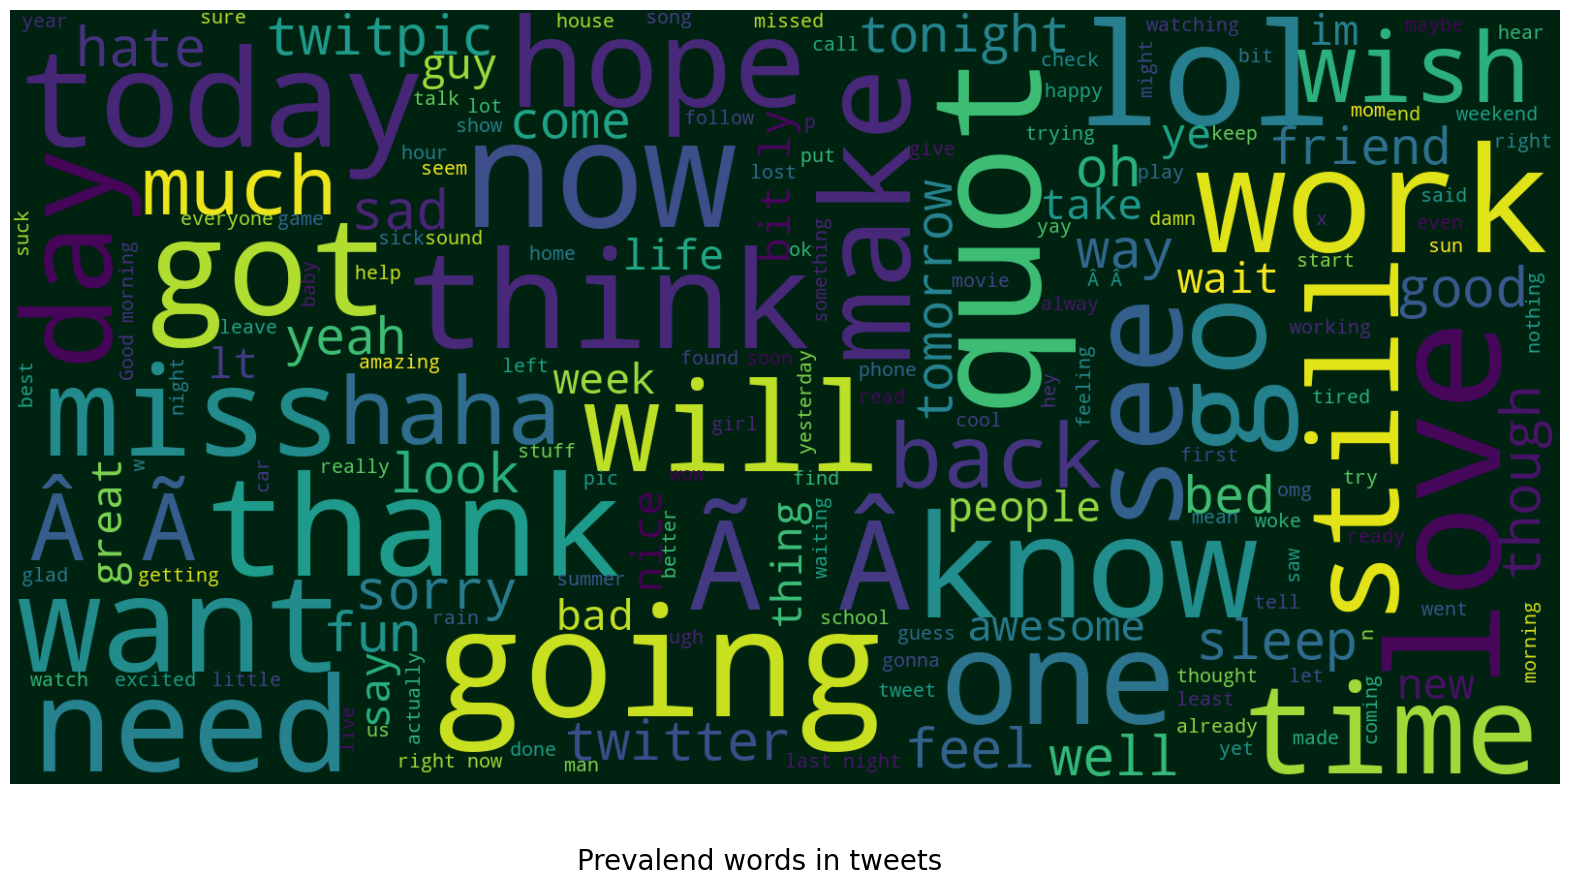

In [52]:
show_wordcloud(project_tweets['tweets'] , title = 'Prevalend words in tweets')

## Hastag Analysis

Top 5 Hashtags:
#followfriday: 2288
#fb: 1765
#squarespace: 867
#ff: 822
#seb-day: 498


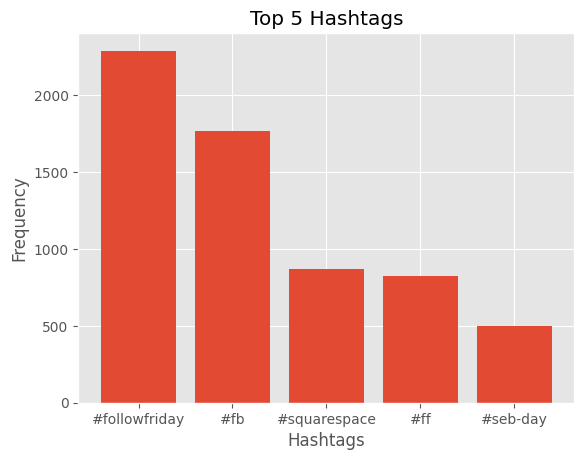

In [53]:
# Extract hashtags from the 'text' column
def extract_hashtags_from_text(text):
    words = text.split()
    return [word.lower() for word in words if word.startswith("#")]

# Apply the function to the 'text' column
project_tweets['hashtags'] = project_tweets['tweets'].apply(extract_hashtags_from_text)

# Flatten the list of hashtags
all_hashtags = [tag for sublist in project_tweets['hashtags'].tolist() for tag in sublist]

# Analyze and plot hashtag frequencies
top_n = 5
hashtag_counts = Counter(all_hashtags)
top_hashtags = dict(hashtag_counts.most_common(top_n))

# Display the list of hashtags and their frequencies
print("Top {} Hashtags:".format(top_n))
for hashtag, frequency in top_hashtags.items():
    print(f"{hashtag}: {frequency}")

# Plot the hashtag frequencies
plt.bar(top_hashtags.keys(), top_hashtags.values())
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top {} Hashtags'.format(top_n))
plt.show()

## Preprocessing Dataset

In [54]:
import re

In [55]:
def depure_data(data):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    return data

In [56]:
temp = []
#Splitting pd.Series to list
data_to_list = project_tweets["tweets"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

[' - Awww, thats a bummer. You shoulda got David Carr of Third Day to do it. ;D',
 'is upset that he cant update his Facebook by texting it... and might cry as a result School today also. Blah!',
 'I dived many times for the ball. Managed to save 50% The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 'no, its not behaving at all. im mad. why am i here? because I cant see you all over there. ']

In [57]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it'], ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'result', 'school', 'today', 'also', 'blah'], ['dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds'], ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'], ['no', 'its', 'not', 'behaving', 'at', 'all', 'im', 'mad', 'why', 'am', 'here', 'because', 'cant', 'see', 'you', 'all', 'over', 'there'], ['not', 'the', 'whole', 'crew'], ['need', 'hug'], ['hey', 'long', 'time', 'no', 'see', 'yes', 'rains', 'bit', 'only', 'bit', 'lol', 'im', 'fine', 'thanks', 'hows', 'you'], ['nope', 'they', 'didnt', 'have', 'it'], ['que', 'me', 'muera']] 



In [58]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['awww thats bummer you shoulda got david carr of third day to do it', 'is upset that he cant update his facebook by texting it and might cry as result school today also blah', 'dived many times for the ball managed to save the rest go out of bounds', 'my whole body feels itchy and like its on fire', 'no its not behaving at all im mad why am here because cant see you all over there']


## Sentiment Analysis

In [59]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [60]:
project_tweets['sentiment'] = project_tweets['tweets'].apply(lambda x: find_sentiment(x))
project_tweets.head(10)

,number,id,date,query,username,tweets,hashtags,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",[],Negative
1,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,[],Negative
2,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,[],Positive
3,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,[],Negative
4,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",[],Negative
5,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,[],Neutral
6,6,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug,[],Positive
7,7,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,[],Positive
8,8,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it,[],Neutral
9,9,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?,[],Neutral


## Encoding

In [61]:
import tensorflow as tf

In [62]:
# Label Encoding
labels = np.array(project_tweets["sentiment"])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [63]:
# total sentiment analysis and show plotly

def plot_sentiment(tw, feature, title):
    counts = tw[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='red')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}\n")
    plt.tight_layout()
    plt.show()

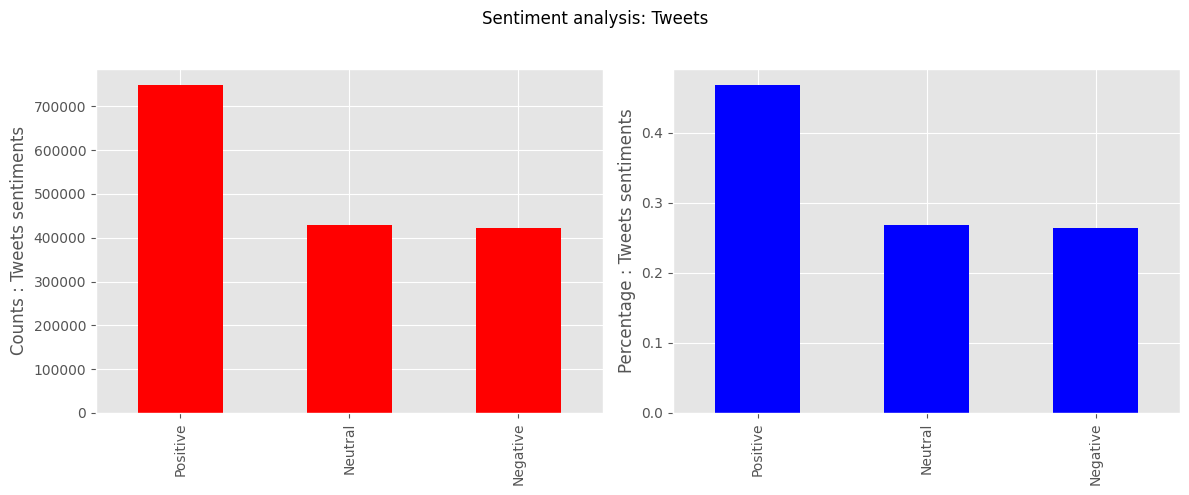

In [64]:
# visiualisiation

plot_sentiment(project_tweets, 'sentiment', 'Tweets')

## Time Series

In [65]:
# Convert the 'date' column to datetime format
project_tweets['date'] = pd.to_datetime(project_tweets['date'])

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [66]:
# Set the 'date' column as the index
project_tweets.set_index('date', inplace=True)

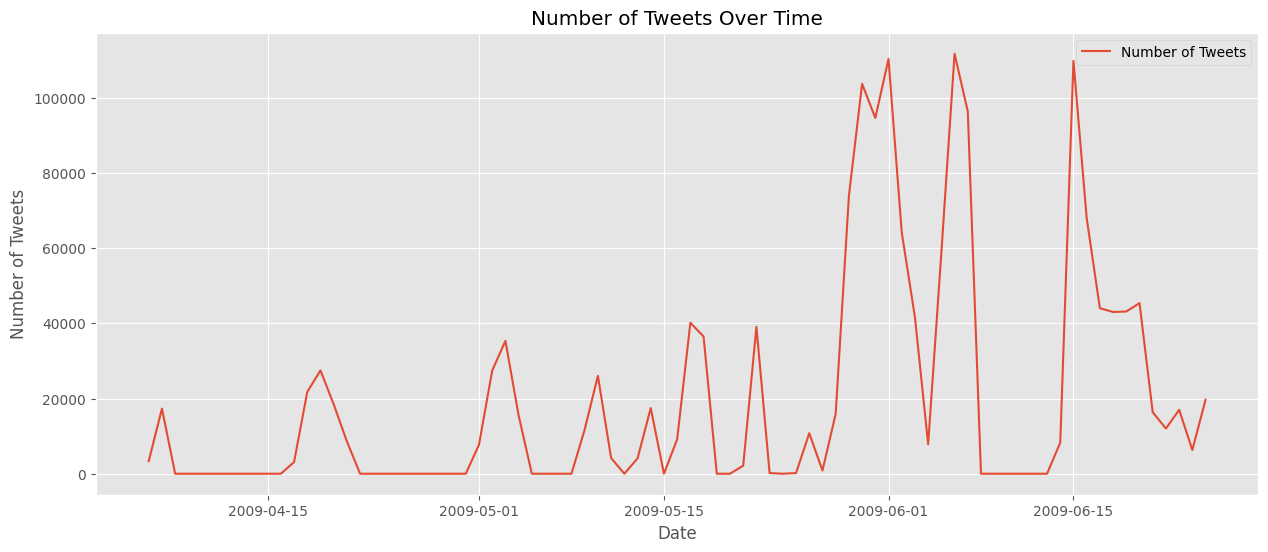

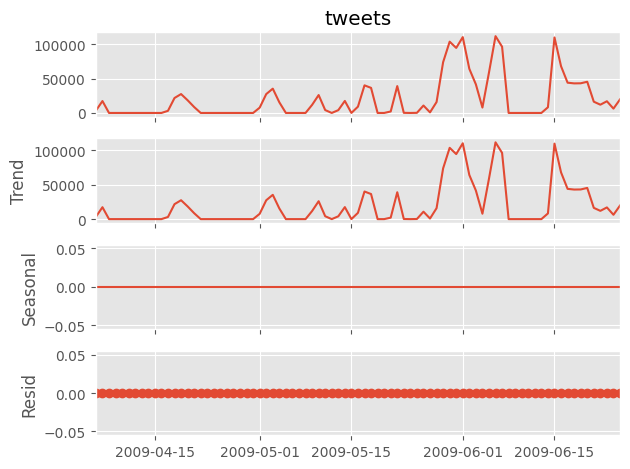

In [67]:
# Resample the data to a specific time frequency (e.g., daily)
df_resampled = project_tweets.resample('D').count()

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(df_resampled.index, df_resampled['tweets'], label='Number of Tweets')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()

# Decompose the time series into trend, seasonality, and residual components
result = seasonal_decompose(df_resampled['tweets'], model='additive', period=1)
result.plot()
plt.show()

# Create a word cloud from the tweet text
text = ' '.join(project_tweets['tweets'].dropna())
stop_words = set(nltk_stopwords.words('english'))

## Machine Learning  Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# Preprocess the data
# For simplicity, we'll use a binary sentiment label (positive or negative)
project_tweets['sentiment'] = project_tweets['tweets'].apply(lambda x: 1 if x.startswith('positive_indicator') else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(project_tweets['tweets'], project_tweets['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Build a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    320000

    accuracy                           1.00    320000
   macro avg       1.00      1.00      1.00    320000
weighted avg       1.00      1.00      1.00    320000



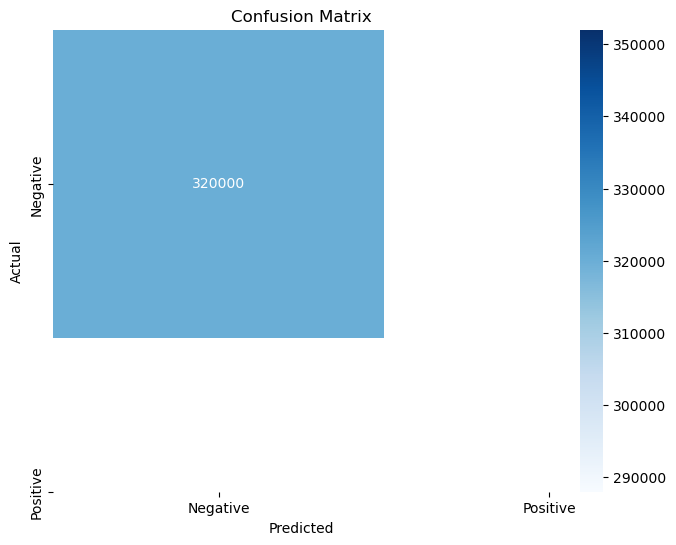

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LSTM (Long Short-Term Memory)

In [19]:
# Preprocess the data
# For simplicity, we'll use a binary sentiment label (positive or negative)
project_tweets['sentiment'] = project_tweets['tweets'].apply(lambda x: 1 if x.startswith('positive_indicator') else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(project_tweets['tweets'], project_tweets['sentiment'], test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 5000  # Set the maximum number of words to consider in the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_length = 50  # Set the maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Build the LSTM model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
32000/32000 [==============================] - 867s 27ms/step - loss: 2.1614e-04 - accuracy: 1.0000 - val_loss: 9.4147e-11 - val_accuracy: 1.0000
Epoch 2/5
32000/32000 [==============================] - 937s 29ms/step - loss: 4.6575e-11 - accuracy: 1.0000 - val_loss: 2.6322e-11 - val_accuracy: 1.0000
Epoch 3/5
32000/32000 [==============================] - 858s 27ms/step - loss: 1.9831e-11 - accuracy: 1.0000 - val_loss: 1.5319e-11 - val_accuracy: 1.0000
Epoch 4/5
32000/32000 [==============================] - 891s 28ms/step - loss: 1.2792e-11 - accuracy: 1.0000 - val_loss: 1.0770e-11 - val_accuracy: 1.0000
Epoch 5/5
10000/10000 [==============================] - 102s 10ms/step - loss: 8.3347e-12 - accuracy: 1.0000
Test Accuracy: 100.00%


Epoch 1/5
32000/32000 [==============================] - 794s 25ms/step - loss: 7.4981e-12 - accuracy: 1.0000 - val_loss: 6.8184e-12 - val_accuracy: 1.0000
Epoch 2/5
32000/32000 [==============================] - 831s 26ms/step - loss: 6.2814e-12 - accuracy: 1.0000 - val_loss: 5.7740e-12 - val_accuracy: 1.0000
Epoch 3/5
32000/32000 [==============================] - 794s 25ms/step - loss: 5.3312e-12 - accuracy: 1.0000 - val_loss: 4.9251e-12 - val_accuracy: 1.0000
Epoch 4/5
32000/32000 [==============================] - 793s 25ms/step - loss: 4.5898e-12 - accuracy: 1.0000 - val_loss: 4.3292e-12 - val_accuracy: 1.0000
Epoch 5/5
32000/32000 [==============================] - 796s 25ms/step - loss: 4.1222e-12 - accuracy: 1.0000 - val_loss: 3.9225e-12 - val_accuracy: 1.0000


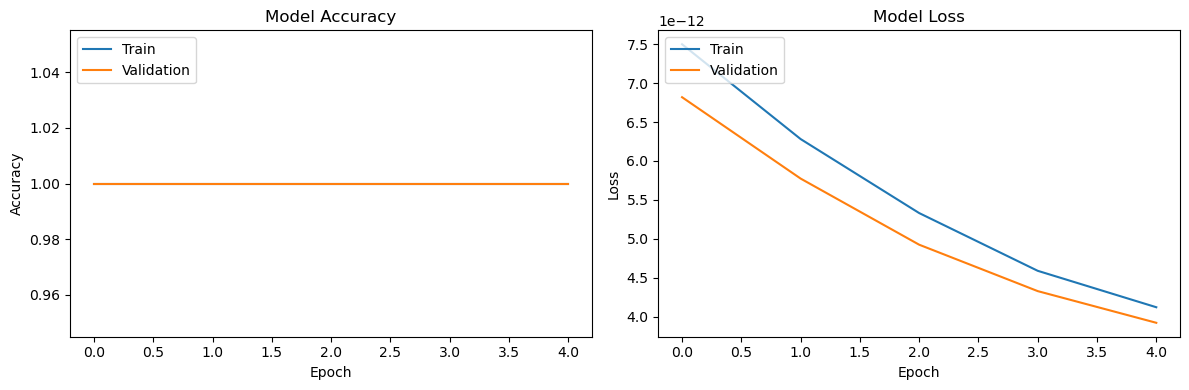

In [20]:
# Train the model with history tracking
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Convolutional Neural Network (CNN)

Epoch 1/5
32000/32000 [==============================] - 210s 7ms/step - loss: -174273297377132544.0000 - accuracy: 0.0000e+00 - val_loss: -629602966772383744.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
32000/32000 [==============================] - 217s 7ms/step - loss: -2048528563572834304.0000 - accuracy: 0.0000e+00 - val_loss: -4144948829994614784.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
32000/32000 [==============================] - 211s 7ms/step - loss: -7986778247129989120.0000 - accuracy: 0.0000e+00 - val_loss: -12890098179952869376.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
32000/32000 [==============================] - 213s 7ms/step - loss: -20311597158278103040.0000 - accuracy: 0.0000e+00 - val_loss: -29173148505734119424.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
32000/32000 [==============================] - 215s 7ms/step - loss: -41313436930148401152.0000 - accuracy: 0.0000e+00 - val_loss: -55257742460766388224.0000 - val_accuracy: 0.0000e+00


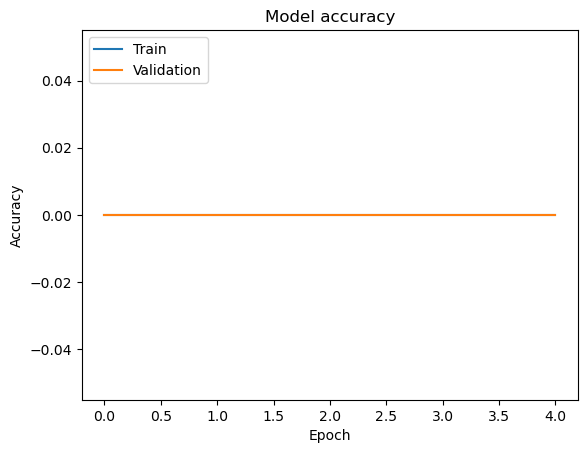

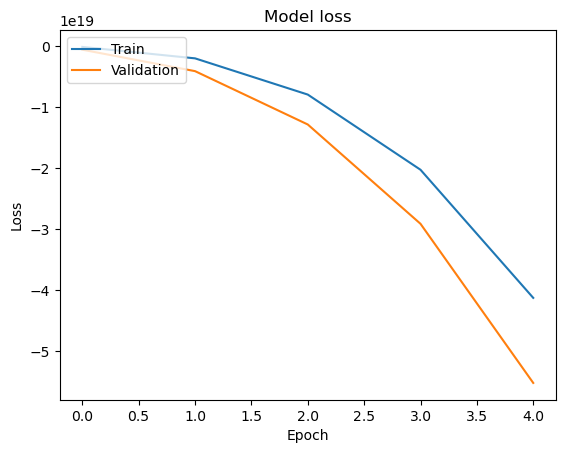

10000/10000 [==============================] - 21s 2ms/step
CNN Accuracy: 0.0


In [21]:
# write your dataset has 'text' and 'target' columns
texts = project_tweets['tweets']
labels = project_tweets['id']

# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, labels, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the history
plot_history(history)

# Evaluate accuracy on the test set
y_pred = model.predict(X_test_padded)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'CNN Accuracy: {accuracy}')